In [85]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix   
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_digits
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from keras.optimizers import SGD
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Diabetes dataset for regression or classification: 
# The goal of the script is to first classify if a patient 
# has diabetes or not based on multiple features like:
#   Patient age
#   Patient sex
#   Patient BMI
#   Patient average blood pressure
#   Six blood serum measurements
# All of these features are measured on 442 patients, and used
# as an indicator of disease progression after one year.

# First we load the dataset
# Here we see that the "x" value represents each person and their
# 10 features. While the "y" values represents each person.
# The diabetes dataset is returned as a "regression" dataset
data = load_diabetes()
x, y = data['data'], data['target']
print(data["feature_names"])
print(x.shape)
print(y.shape)
print(x[0][0])

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
(442, 10)
(442,)
0.0380759064334241


In [86]:
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x, y, test_size=0.2, random_state=42)

# Since the diabetes dataset is loaded as a regression dataset,
# we have to convert it to a classification problem.

# First we create an array of zeros with the same size as "y"
# Then we set each element to 1 in our "y_" array, where in the "y" array
# the correspoding element is bigger than 140. Then we convert the values
# of decimals in "y_" to integers.
y_ = np.zeros(y.shape)
y_[y > 140] = 1.
y_ = y_.astype(int)

# Then we split our data into 80% training data and 20% testing data
# The "random_state" parameter is used for reprodruction of the data. 
# The stratify parameter makes sure that "y_" is equally represented 
# in both training and test. This type of setup is called holdout.
x_train_labeled, x_test_labeled, y_train_labaled, y_test_labaled = train_test_split(x, y_, test_size=0.2, random_state=42, stratify=y_)

In [87]:
# Standardise the data so that all the data has a range between 0 and 1, 
# instead of between -1 and 1. This is to scale our features correctly.
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_standarized_labeled = min_max_scaler.fit_transform(x_train_labeled)
x_test_standarized_labeled = min_max_scaler.fit_transform(x_test_labeled)

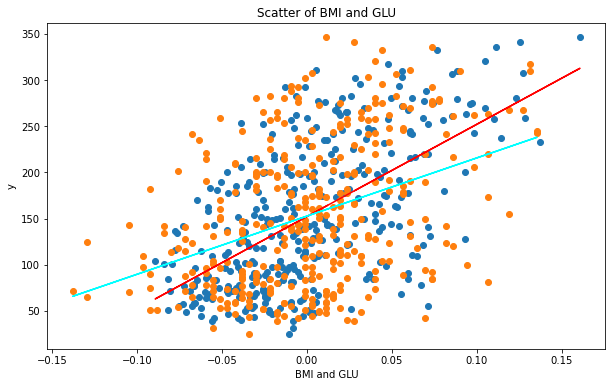

In [88]:
bmi = x_train_normal[:, np.newaxis, 2]
glu = x_train_normal[:, np.newaxis, 9]

y = y_train_normal[:, np.newaxis]

bmi_linear_regression = LinearRegression().fit(bmi, y_train_normal)
bmi_predicted_y = bmi_linear_regression.predict(bmi)

glu_linear_regression = LinearRegression().fit(glu, y_train_normal)
glu_predicted_y = glu_linear_regression.predict(glu)

# Plotting of the regression line on a scatterd plot
plt.figure(figsize=(10,6))
plt.scatter(bmi, y_train_normal)
plt.scatter(glu, y_train_normal)
plt.plot(bmi, bmi_predicted_y, c='r')
plt.plot(glu, glu_predicted_y, c='cyan')
plt.title('Scatter of BMI and GLU')
plt.ylabel('y')
plt.xlabel('BMI and GLU')
plt.show()

In [89]:
def select_features(train_data, y_data, test_data, n_features='all', regression=True):
    score_function = f_regression
    if (regression):
        score_function = chi2

    k_best = SelectKBest(score_func=score_function, k=n_features)
    k_best.fit(train_data, y_data)
    
    x_train_k_best = k_best.transform(train_data)
    x_test_k_best = k_best.transform(test_data)

    return x_train_k_best, x_test_k_best, k_best

def plot_k_best_score(scores):
    plt.bar([i for i in range(len(scores))], scores)
    plt.title('Score value of each feature')
    plt.xlabel('Feature')
    plt.ylabel('Score')
    plt.show()

def pca_features(dataset, transform, n_features=5):
    pca = PCA(n_components=n_features).fit(dataset)

    transformed = pca.transform(transform)

    return transformed, pca

def plot_pca_variance(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA coverage features')
    plt.xlabel('Features')
    plt.ylabel('Coverage')
    plt.show()

def print_percent_correct(predicted, test):
    print('Percentage correct:', 100*np.sum(predicted == test) / len(test))

def plot_matrix(title, matrix):
    cmap = ListedColormap(['darkorange', 'gold', 'blue', 'red'])

    plt.figure()
    plt.matshow(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(x=j, y=i, s=matrix[i,j], va='center', ha='center')
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

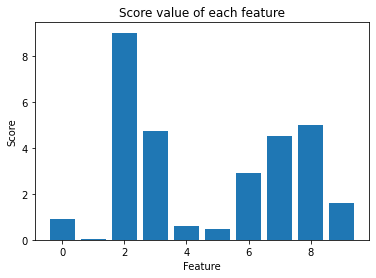

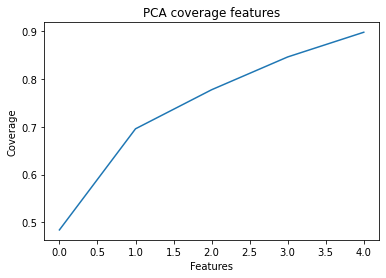

In [90]:
features = 5

x_trainset_features = x_train_standarized_labeled
y_trainset_features = y_train_labaled
x_testset_features = x_test_standarized_labeled

x_train_k_best, x_test_k_best, k_best = select_features(x_trainset_features, y_trainset_features, x_testset_features, n_features=features)
plot_k_best_score(k_best.scores_)

transformed, pca = pca_features(dataset=x_trainset_features, transform=x_trainset_features, n_features=features)
x_train_pca = transformed
transformed, pca = pca_features(dataset=x_trainset_features, transform=x_testset_features, n_features=features)
x_test_pca = transformed
plot_pca_variance(pca)

# VERY IMPORTANT! SET TRAINING DATA HERE!
x_train = x_train_k_best
x_test = x_test_k_best
y_train = y_train_labaled
y_test = y_test_labaled

In [91]:
predicter = Sequential()

predicter.add(Dense(units=features*2, activation='relu', input_dim=features, name='Input'))
predicter.add(Dense(units=10, activation='relu', name='Hidden1'))
predicter.add(Dense(units=5, activation='relu', name='Hidden2'))
predicter.add(Dense(units=1, activation='sigmoid', name='Output'))

predicter.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

svc_clf = SVC(random_state=42, kernel='rbf', c=2200, gamma=0.0001)
svc_clf.fit(x_train, y_train)
y_pred_svc = svc_clf.predict(x_test)
svc_clf.get_params

cm = confusion_matrix(y_true=y_test, y_pred=y_pred_svc)
plot_matrix('SVC Classifier', cm)
print_percent_correct(y_pred_svc, y_test)

